In [1]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import time, timedelta

In [2]:
# This method takes in paramaters:
# 1) recover_folder: Name of the folder where the detections are stored.
# 2) audio_dur: The AudioMoth's configuration for the length of each recording.

# This method returns:
# - A DataFrame object that has columns:
#   - File Names, Date, Start Time, End Time, # of LF detections, # of HF detections
#   - File Names are strings and # of LF/HF detections are integers.
#   - Times are in UTC format and Dates are datetime.datetime objects.

def generate_df(recover_folder, audio_dur=pd.DateOffset(minutes=29, seconds=55)):

    # detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
    detection_dir = f"detections/{recover_folder}"

    # Construct path object linked to the directory of files for datetime-parsing
    file_dir = Path(detection_dir)
    # We use this to only extract the original file names of the recordings.
    # The detection files will be assembled below.
    sorted_files = sorted(file_dir.glob('hf_*.txt'))

    # Create empty DataFrame object with all the required columns    
    df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Iterate through all file paths to extract and store table information for each file
    for i, file in enumerate(sorted_files):
        # Extract name of each file as it is
        file_name = file.name
        # Extracting the datetime object from the name of each file
        file_info = dt.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")

        # Extract recording name, date, start time, and end time for each file
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        date = file_info.date()
        s_time = file_info.time()
        e_time = (file_info+audio_dur).time()

        # Calling read_detection to return the table of selections as a dataframe
        # The detections appear twice: in waveform view and spectrogram view, 
        # so we half the total number of detections
        lf_file_detections = read_detection(detection_dir, recording_name, "lf")
        num_lf_detections = lf_file_detections.shape[0]/2
        hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
        num_hf_detections = hf_file_detections.shape[0]/2
        
        # Add new row with the extracted information
        df.loc[len(df.index)] = [recording_name, date, s_time, e_time, num_lf_detections, num_hf_detections]
    
    return df

In [3]:
def generate_all_df_from_site(field_records, site_name):
    cond3 = field_records["Site"]==site_name
    df_site = field_records[cond3]
    dfs = []

    for index, row in df_site.iterrows():
        folder_name = row["Upload folder name"]
        sd_card = row["SD card #"]
        recover_folder = f"{folder_name}-{sd_card:03}-detect" 

        if (folder_name!="UPLOAD_FOLDER"):
            df = generate_df(recover_folder)
            dfs.append(df)

    return pd.concat(dfs)

In [4]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [16]:
def plot_separate(df, site, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()

    # Here we also construct a time vector to make each plot comparable
    s_times = []
    i=0
    s_times.append(time(0, 0, 0))
    while (s_times[i] != time(hour=23, minute=30, second=0)):
        old_dt = (dt.combine(unique_dates[0], s_times[i]))
        new_dt = old_dt+pd.DateOffset(minutes=30)
        s_times.append(new_dt.time())
        i+=1
    
    # We plot for each date in our unique dates
    for date in unique_dates:
        day_df = df.loc[df['Date'] == date]
        
        # Create empty DataFrame object with all the required columns    
        pad_df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
        
        s_time = day_df["Start Time (UTC)"].iloc[0]
        st_row = time(0, 0, 0)
        
        while (st_row < s_time):
            file_info = dt.combine(date, st_row)
            recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
            e_time = (file_info+pd.DateOffset(minutes=29, seconds=55)).time()
            pad_df.loc[len(pad_df.index)] = [recording_name, date, st_row, e_time, None, None]
            st_row = (file_info+pd.DateOffset(minutes=30)).time()

        day_df = pd.concat([pad_df, day_df])
        
        fig = day_df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
        fig.set_title(f"{date} in {site}", fontsize=14)
        # Here we set the time vector we constructed
        fig.set_xticks(range(len(s_times)), s_times)      
        
        # If the user wants to save, it goes into the below path
        if save:
            save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{recover_folder}/FIGS"
            save_dir = Path(save_folder)
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = Path(f"{save_folder}/{date}.png")
            fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [17]:
def plot_total(df, site, save=False):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    fig = df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
    fig.set_title(f"Total Deployment Session from {unique_dates[0]} to {unique_dates[-1]} in {site}", fontsize=14)
    fig.set_xticks(fig.get_xticks()[::len(unique_dates)])
    
    # If the user wants to save, it goes into the below path
    if save:
        save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{site}"
        save_dir = Path(save_folder)
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = Path(f"{save_folder}/activity.png")
        fig.get_figure().savefig(save_path, facecolor='w', bbox_inches = "tight")

In [18]:
def get_field_records():
    path_to_records = Path(f"ubna_2022b.csv")

    if (path_to_records.is_file()):
        fr = pd.read_csv(path_to_records, sep=',') 

    return fr

In [19]:
def get_site_name(fr, DATE, SD_CARD_NUM):
    cond1 = fr["Upload folder name"]==f"recover-{DATE}"
    cond2 =  fr["SD card #"]==int(SD_CARD_NUM)
    site = fr.loc[cond1&cond2, "Site"]
    
    if (site.empty):
        site_name = "Foliage"
    else:
        site_name = site.item()
    
    return site_name

In [26]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220801"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "004"

field_records = get_field_records()
site_name = get_site_name(field_records, DATE, SD_CARD_NUM)

In [27]:
recover_folder = f"recover-{DATE}-{SD_CARD_NUM}-detect"
df = generate_df(recover_folder)
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220729_013743.WAV,2022-07-29,01:37:43,02:07:38,9.0,4.0
1,20220729_020000.WAV,2022-07-29,02:00:00,02:29:55,0.0,0.0
2,20220729_023000.WAV,2022-07-29,02:30:00,02:59:55,0.0,0.0
3,20220729_030000.WAV,2022-07-29,03:00:00,03:29:55,0.0,0.0
4,20220729_033000.WAV,2022-07-29,03:30:00,03:59:55,0.0,0.0
...,...,...,...,...,...,...
172,20220801_153000.WAV,2022-08-01,15:30:00,15:59:55,0.0,0.0
173,20220801_160000.WAV,2022-08-01,16:00:00,16:29:55,0.0,0.0
174,20220801_163000.WAV,2022-08-01,16:30:00,16:59:55,0.0,0.0
175,20220801_170000.WAV,2022-08-01,17:00:00,17:29:55,0.0,0.0


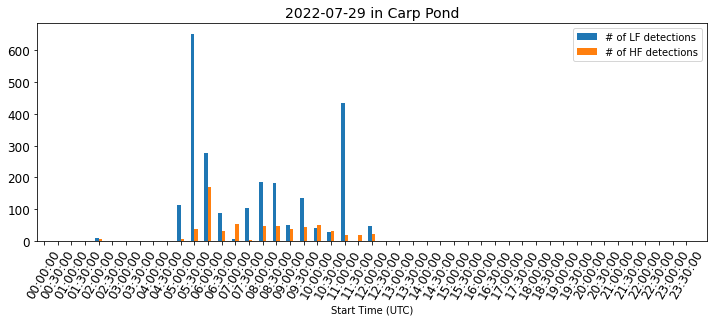

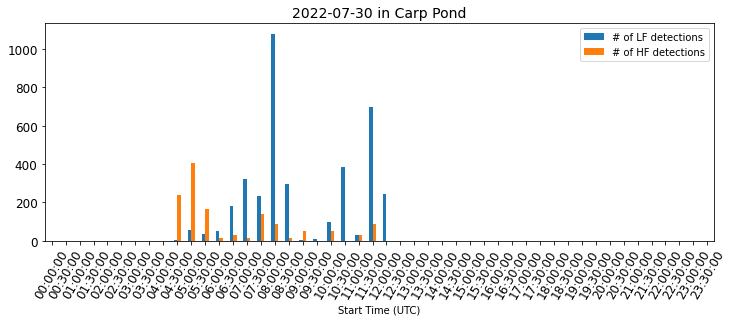

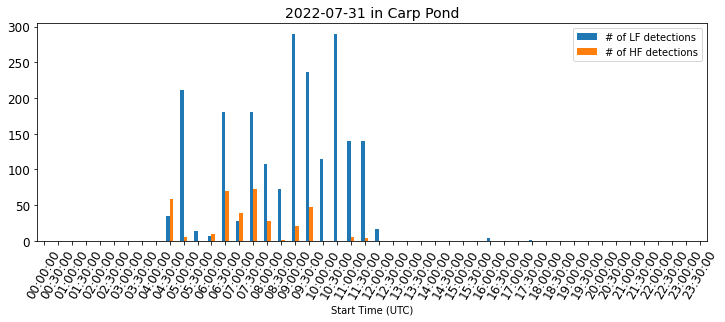

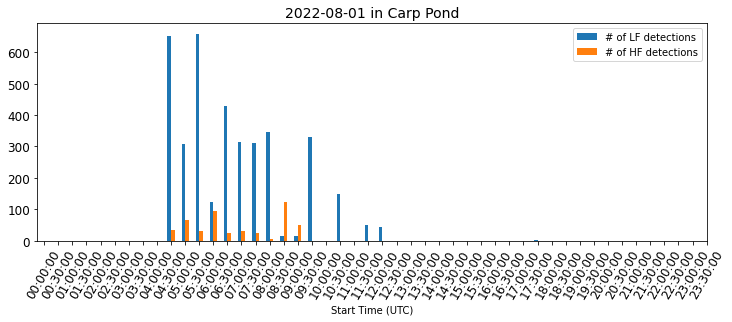

In [28]:
plot_separate(df, site_name, save=True)

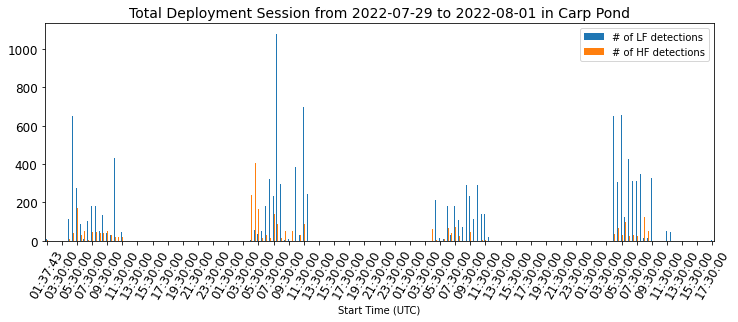

In [29]:
plot_total(df, site_name)

In [23]:
df_all = generate_all_df_from_site(field_records, site_name)
if (df_all.empty):
    df_all = pd.concat([df, df_all])

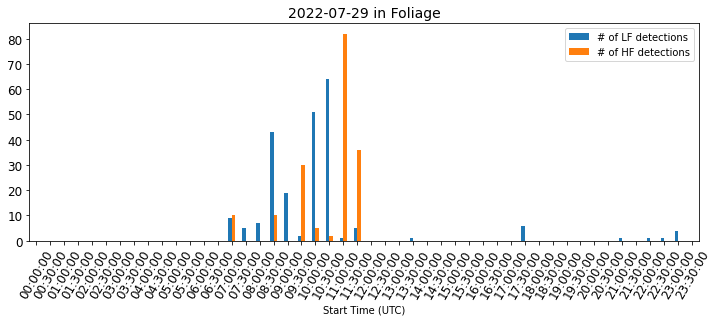

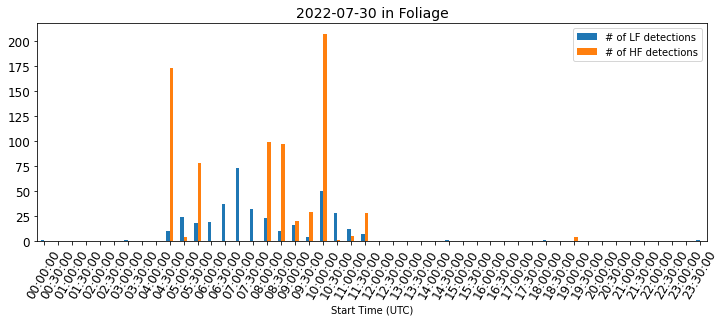

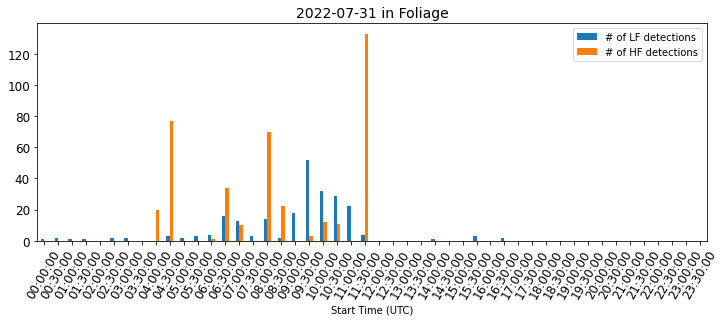

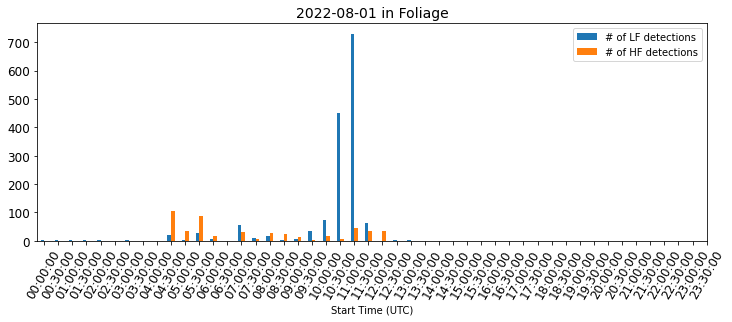

In [24]:
plot_separate(df_all, site_name, save=False)

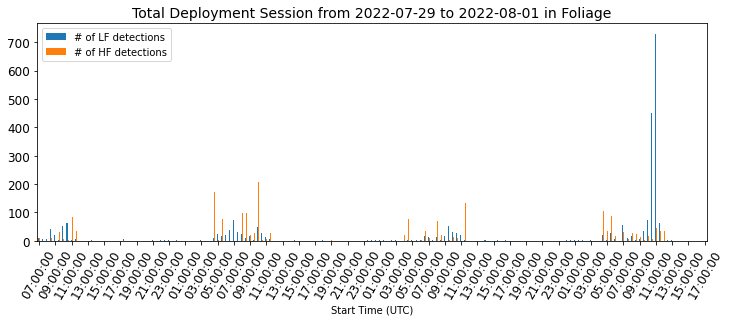

In [25]:
plot_total(df_all, site_name, save=True)